In [2]:
# Basic tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# DL tools
import torch 
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

# OS tool
import os

2023-01-25 14:15:13.197754: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
device = torch.device('cuda')
print('device:', device)

device: cuda


In [4]:
# Loading the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Min-Max scaling
x_train = x_train/255.0
x_test = x_test/255.0

# Split train data into Train/Validation data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle=True)

# Check data shape
print(f"Train 데이터 크기: {x_train.shape, y_train.shape}")
print(f"Validation 데이터 크기: {x_val.shape, y_val.shape}")
print(f"Test 데이터 크기:{x_test.shape, y_test.shape}")


Train 데이터 크기: ((48000, 28, 28), (48000,))
Validation 데이터 크기: ((12000, 28, 28), (12000,))
Test 데이터 크기:((10000, 28, 28), (10000,))


첫번째 이미지 라벨: 8 
두번째 이미지 라벨: 0 


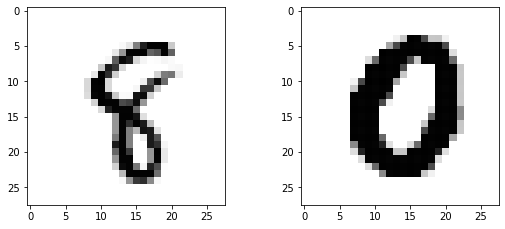

In [5]:
# Check
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(211)
img1 = plt.imshow(x_train[0].reshape(28, 28)).set_cmap('Greys')
ax2 = fig.add_subplot(222)
img2 = plt.imshow(x_train[1].reshape(28, 28)).set_cmap('Greys')
print(f"첫번째 이미지 라벨: {y_train[0]} ")
print(f"두번째 이미지 라벨: {y_train[1]} ")

In [6]:
class Mydataset(torch.utils.data.Dataset):

    # 데이터 전처리 
    def __init__(self, dataX_np , dataY_np):
        self.data_X = dataX_np.astype(np.float32)
        self.data_Y = dataY_np.astype(np.float32) 

        print(f"My_dataset __init__ received : {self.data_X.shape}, {self.data_Y.shape} ")

    # 인덱스를 입력받아 인덱스에 알맞는 입출력 데이터를 Return
    def __getitem__(self, index):
        image = self.data_X[index]
        label = self.data_Y[index]
        # One hot encoding
        # 0~9 숫자로 되어있는 라벨을 one hot encoding 형식으로 변환합니다. 이는 이후 MLP의 출력이 10차원이기에 Loss를 계산하기 위해 진행하였습니다.  
        label = to_categorical(label, num_classes = 10)

        return image, label
    
    # 총 데이터 개수를 Return
    def __len__(self):
        return len(self.data_X)

In [49]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(Mydataset(x_train.reshape(-1,28*28), y_train), batch_size=batch_size, shuffle=False, drop_last = False)
valid_loader = torch.utils.data.DataLoader(Mydataset(x_val.reshape(-1,28*28), y_val), batch_size = 1000000000, shuffle=False, drop_last = False)
test_loader = torch.utils.data.DataLoader(Mydataset(x_test.reshape(-1,28*28), y_test), batch_size = 100000000, shuffle=False, drop_last = False)

My_dataset __init__ received : (48000, 784), (48000,) 
My_dataset __init__ received : (12000, 784), (12000,) 
My_dataset __init__ received : (10000, 784), (10000,) 


In [44]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = F.relu(x) 
        x = self.fc3(x)

        # Pytorch에서는 Softmax가 CrossEntropy함수안에 내장되어있기에 없어도 됩니다. 
        # 이후 Loss를 CrossEntropy를 사용할 것이기에 제외하였습니다.
        # x = F.log_softmax(x, dim=1)

        return x

In [33]:
from statistics import mean 
import time

def train(model, criterion_, optimizer_, scheduler_, num_epochs=40, first_epoch=1):
    
    train_losses = []
    valid_losses = []
    test_losses = []

    print("----------------------------------------------------------------------------")

    start_time = time.time()
    for epoch in range(first_epoch, first_epoch + num_epochs):
        # train phase
        model.train()
        
        # batch_loss 
        batch_losses = []

        for images, labels in train_loader:
            
            # Move the training data to the GPU
            images = images.to(device)   
            labels = torch.argmax(labels, dim=1).long().to(device)
            

            # clear previous gradient computation
            optimizer_.zero_grad()

            # forward propagation
            outputs = model(images)

            # calculate the loss
            loss = criterion_.forward(outputs, labels)
            batch_losses.append(loss.item())

            # backpropagate to compute gradients
            loss.backward()

            # update model weights
            optimizer_.step()

        # Train loss를 저장합니다.
        train_losses.append(mean(batch_losses))

        # validation phase
        # Dropout, BatchNormalization과 같은 layer가 동작하지 않도록 합니다.
        model.eval()

        # We don't need gradients for test, so wrap in 
        # no_grad to save memory
        # 기울기 Gradient를 계산하지 않으며 backpropagation을 하지 않습니다. 
        with torch.no_grad():
            
            correct_test = 0

            for images, labels in valid_loader:

                # Move the training batch to the GPU
                images = images.to(device)
                labels = torch.argmax(labels, dim=1).long().to(device)

                # forward propagation
                outputs = model(images)

                # calculate the loss
                loss = criterion_(outputs, labels)
                valid_losses.append(loss.item())

            for images, labels in test_loader:
                # Move the training batch to the GPU
                images = images.to(device)
                labels = torch.argmax(labels, dim=1).long().to(device)

                # forward propagation
                outputs = model(images)

                # calculate the loss
                loss = criterion_(outputs, labels)
                test_losses.append(loss.item())

                # Check Accuracy
                # preds 는 output 중에서 가장 높은 값의 index를 가집니다. 
                _, preds = torch.max(outputs, 1)

                # label이 현재 one hot encoding 형태로 되어있기에 preds를 index로 받아 1인지 확인합니다. 
                # ex) 숫자 2 : label = [0,0,1,0,0,...,0] , label[i][preds] == 1 -> 정답
                for i in range(len(preds)):
                  if labels[i] == preds[i]:
                    correct_test +=1
        
        # 원하는 Epoch마다 결과 출력 
        if (epoch) % 1== 0 :
            curr_time = round(time.time()-start_time)
            train_rec = round(train_losses[-1],5)
            valid_rec = round(valid_losses[-1],5)
            test_rec = round(test_losses[-1],5)
            test_acc = round(100*(correct_test)/len(labels),3)
            print('Epoch', epoch, ' / ',num_epochs)
            print(f"\t [Train loss : {train_rec}]  [Validation loss : {valid_rec}] [Test loss : {test_rec}], [Test Accuracy : {test_acc}%],[curr LR = {scheduler_.get_last_lr()}],[elapsed_time = {curr_time}sec] ")

        # Learning rate Scheduling
        # Scheduler에 따라 learning rate를 조절합니다. 
        scheduler_.step()
        
      
    print(f"\nTrain Ended, total_elapsed_time = {round(time.time()-start_time)} ")
    print("--------------------------------------------------------------------")
    
    # Loss 값 반환
    return train_losses, valid_losses, test_losses

In [50]:
# Moodel Setting 
model = MLP()
model.to(device)

# Optimizer
# Optimzer와 Learning rate를 설정해줍니다.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
# epoch가 10번 돌때마다 learning rate를 gamma만큼 곱해 사용합니다. ex) 0.01 -> 0.005
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

## Training

In [51]:
train_losses, valid_losses, test_losses = train(model, criterion_ = criterion, optimizer_ = optimizer, scheduler_ = scheduler, num_epochs=15)

----------------------------------------------------------------------------
Epoch 1  /  15
	 [Train loss : 0.32998]  [Validation loss : 0.16347] [Test loss : 0.16155], [Test Accuracy : 95.33%],[curr LR = [0.01]],[elapsed_time = 2sec] 
Epoch 2  /  15
	 [Train loss : 0.24156]  [Validation loss : 0.16273] [Test loss : 0.15758], [Test Accuracy : 95.7%],[curr LR = [0.01]],[elapsed_time = 4sec] 
Epoch 3  /  15
	 [Train loss : 0.22091]  [Validation loss : 0.15374] [Test loss : 0.14682], [Test Accuracy : 96.07%],[curr LR = [0.01]],[elapsed_time = 6sec] 
Epoch 4  /  15
	 [Train loss : 0.21462]  [Validation loss : 0.14764] [Test loss : 0.14827], [Test Accuracy : 96.38%],[curr LR = [0.01]],[elapsed_time = 8sec] 
Epoch 5  /  15
	 [Train loss : 0.20678]  [Validation loss : 0.15663] [Test loss : 0.1521], [Test Accuracy : 96.1%],[curr LR = [0.01]],[elapsed_time = 10sec] 
Epoch 6  /  15
	 [Train loss : 0.2023]  [Validation loss : 0.17815] [Test loss : 0.17447], [Test Accuracy : 95.96%],[curr LR = [0.

# Plot Result
---

In [36]:
def plot_result(train_loss, val_loss, test_loss):
  plt.figure(figsize=(20,8))
  plt.plot(train_loss, label='Train Loss', linewidth='3')
  plt.plot(val_loss, label='Validation Loss', linewidth='3')
  plt.plot(test_loss, label='Test Loss', linewidth='3')
  plt.grid()
  plt.rc('xtick', labelsize=12)
  plt.rc('ytick', labelsize=12)  
  plt.legend()
  plt.rc('legend', fontsize=15)  
  plt.xlabel('Number of Eopch')
  plt.ylabel('Cross Entropy Loss')
  plt.rc('axes', labelsize=17)  


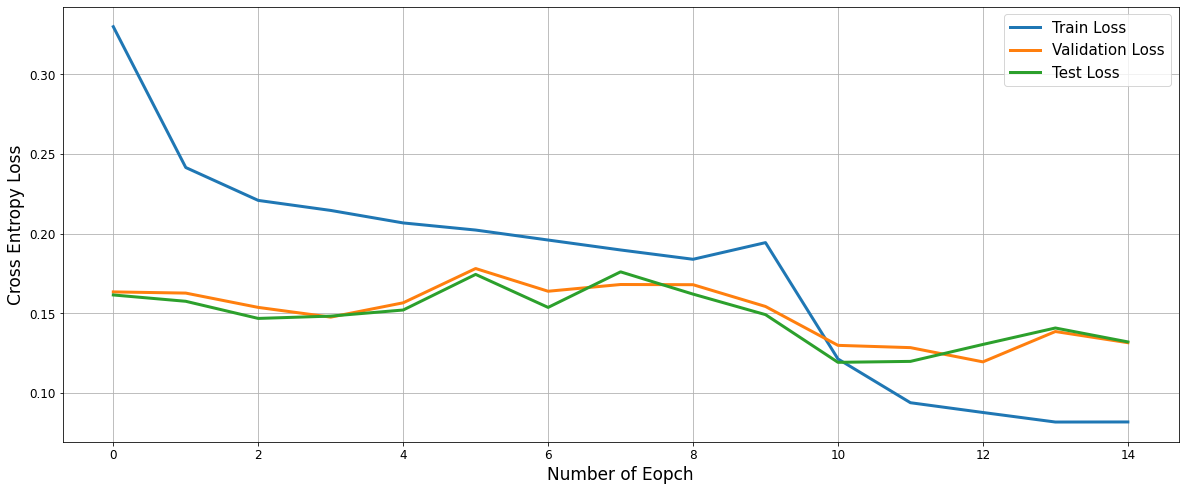

In [52]:
plot_result(train_losses, valid_losses, test_losses)